## Double-Well SDE and PriorVAE

In [1]:
import random as rnd

import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import optax

from priorCVAE.priors import DoubleWellSDE
from priorCVAE.datasets import SDEDataset
from priorCVAE.models import MLPDecoder, MLPEncoder, VAE
from priorCVAE.trainer import VAETrainer
from priorCVAE.utility import save_model_params
from priorCVAE.losses import SquaredSumAndKL

## Configuration

In [2]:
args = {
        # setup
        "t0" : 0,
        "t1" : 20,
        "dt" : 0.01,
        
        # architecture
        "input_dim" : None,  # This is set later depending on the time-grid
        "hidden_dim": [1000, 500, 100],
        "latent_dim": 50,
        
        # VAE training    
        "batch_size": 2000,
        "num_iterations": 1000,
        "learning_rate": 1e-3,
        "vae_var": 2.5
       }

## Simulate the SDE and generate data

In [3]:
base_sde = DoubleWellSDE(c=2, q=3)
x_init = jnp.ones((1, 1))

sde_dataset_generator = SDEDataset(base_sde, x_init, dt=args["dt"], t_lim_high=args["t1"], t_lim_low=args["t0"]) 

In [4]:
sample_t_train, sample_y_train, _ = sde_dataset_generator.simulatedata(n_samples=100)
t_test, y_test, _ = sde_dataset_generator.simulatedata(n_samples=100)

In [5]:
args["input_dim"] = sample_y_train.shape[1]

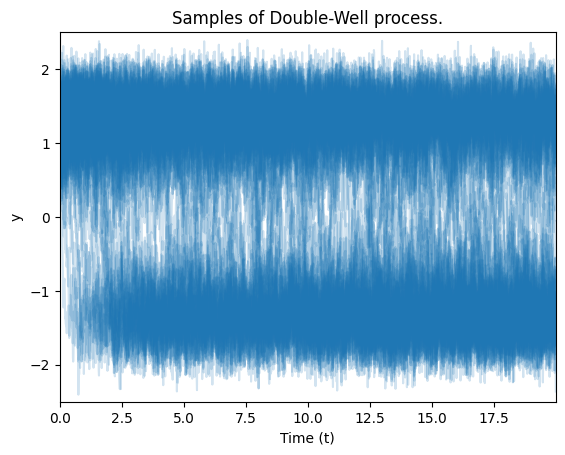

In [6]:
for y_i in sample_y_train:
    plt.plot(sample_t_train[0], y_i, color="tab:blue", alpha=0.2)

plt.xlim([sample_t_train[0][0], sample_t_train[0][-1]])
plt.ylim([-2.5, 2.5])
plt.title("Samples of Double-Well process.")
plt.xlabel("Time (t)")
plt.ylabel("y")
plt.show()

## PriorVAE model

In [7]:
out_dim     = args["input_dim"]
hidden_dim  = args["hidden_dim"]
latent_dim  = args["latent_dim"]
batch_size  = args["batch_size"]
num_iterations  = args["num_iterations"]
learning_rate = args["learning_rate"]
vae_var = args["vae_var"]

decoder_hidden_list = hidden_dim
decoder_hidden_list.reverse()

In [8]:
from flax import linen as nn

In [9]:
encoder = MLPEncoder(hidden_dim, latent_dim)
decoder = MLPDecoder(decoder_hidden_list, out_dim)
model = VAE(encoder, decoder)

optimizer = optax.adam(learning_rate=learning_rate)

In [10]:
encoder, decoder

(MLPEncoder(
     # attributes
     hidden_dim = [100, 500, 1000]
     latent_dim = 50
     activation = sigmoid
 ),
 MLPDecoder(
     # attributes
     hidden_dim = [100, 500, 1000]
     out_dim = 2000
     activation = sigmoid
 ))

## Train the model

In [11]:
loss = SquaredSumAndKL(vae_var=vae_var)
trainer = VAETrainer(model, optimizer)
trainer.init_params(sample_y_train[0])

test_set = (t_test, y_test, _)
loss_vals, test_vals, time_taken = trainer.train(sde_dataset_generator, test_set, num_iterations)

print(f'Training of {num_iterations} iterations took {round(time_taken)} seconds')


[    1] training loss: 199388.047, test loss: 170656.656
[   11] training loss: 158009.062, test loss: 153236.625
[   21] training loss: 156498.516, test loss: 150697.562
[   31] training loss: 156624.984, test loss: 150557.250
[   41] training loss: 150546.641, test loss: 141224.969
[   51] training loss: 138490.266, test loss: 128491.617
[   61] training loss: 128647.422, test loss: 120427.188
[   71] training loss: 125329.938, test loss: 116074.320
[   81] training loss: 120855.617, test loss: 111336.875
[   91] training loss: 111168.062, test loss: 107510.820
[  101] training loss: 114971.164, test loss: 103388.758
[  111] training loss: 108681.000, test loss: 102805.289
[  121] training loss: 103944.453, test loss: 102150.797
[  131] training loss: 107212.797, test loss: 101267.758
[  141] training loss: 101879.266, test loss: 100865.203
[  151] training loss: 107801.109, test loss: 100307.773
[  161] training loss: 101026.297, test loss: 102083.422
[  171] training loss: 109592.4

Text(0.5, 1.0, 'Test loss')

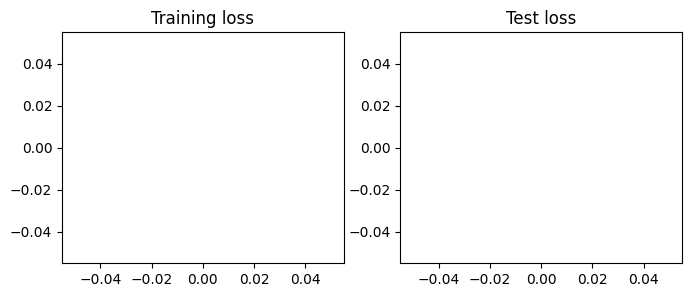

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

skip_initial = 1000

axs[0].plot(range(len(loss_vals) - skip_initial), loss_vals[skip_initial:])
axs[0].set_title('Training loss')

axs[1].plot(range(len(test_vals) - skip_initial), test_vals[skip_initial:])
axs[1].set_title("Test loss")


## Samples from trained decoder

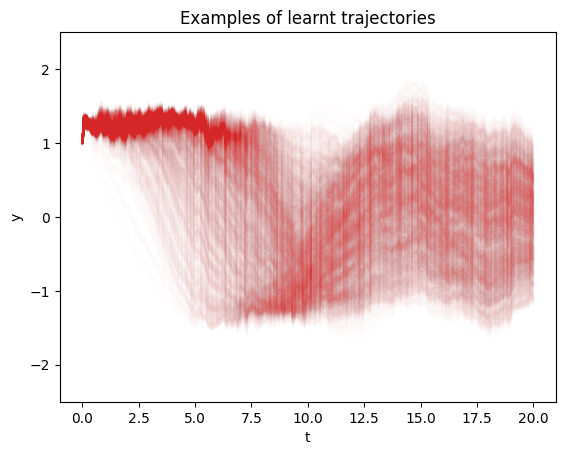

In [13]:
decoder_params = trainer.state.params['decoder']

key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = jax.random.split(key, 3)
z = jax.random.normal(z_rng, (batch_size, latent_dim))

decoder = MLPDecoder(hidden_dim, out_dim)
out = decoder.apply({'params': decoder_params}, z)             

for i in range(1000):
    plt.plot(sample_t_train[0], out[i,:], color="tab:red", alpha=0.01)

# for y_i in sample_y_train:
#     plt.plot(sample_t_train[0], y_i, color="tab:blue", alpha=0.1)

plt.xlabel('t')
plt.ylabel('y')
plt.ylim([-2.5, 2.5])
plt.title('Examples of learnt trajectories')

plt.show()

In [14]:
## Generate 1000 samples
key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = jax.random.split(key, 3)
z = jax.random.normal(z_rng, (2000, latent_dim))

decoder = MLPDecoder(hidden_dim, out_dim)
out = decoder.apply({'params': decoder_params}, z) 

In [15]:
out.shape

(2000, 2000)

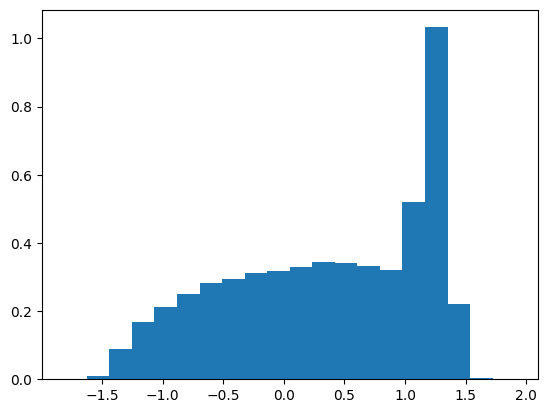

In [16]:
plt.hist(out.reshape(-1), bins=20, density=True)
plt.show()

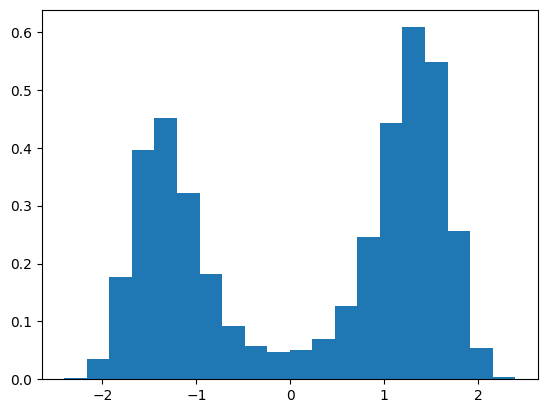

In [17]:
plt.hist(sample_y_train.reshape(-1), bins=20, density=True)
plt.show()

In [18]:
# save_model_params("DW/16000_3_hidden", trainer.state.params)

ValueError: Destination DW/16000_3_hidden already exists.